## 2.1 Entity Name Recognition with BERT

In this section, we will train a BERT model for the task of entity name recognition. We will use the `transformers` library from Hugging Face, which provides pre-trained models and tokenizers for various NLP tasks.

In [2]:
import pandas as pd
import warnings
import ast
import nltk
import numpy as np
from transformers import AutoTokenizer

# suppress warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# download the punkt tokenizer
nltk.download('punkt_tab')

# load the processed data
df = pd.read_csv('patients_with_ratings.csv')

# preview the data
display(df.head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,...,0,0,0,0,0,0,0,5,1,1
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,...,0,0,0,0,0,0,0,2,4,4
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,...,0,1,0,1,0,0,0,5,2,1
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,...,0,0,0,0,1,0,0,1,5,4
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,...,0,0,0,0,0,0,0,3,3,3


### 2.1.1 Data Preprocessing

We will need to prepare our data for training so that the disease names are labeled correctly. We will use the `transformers` library to tokenize our text and create the necessary input format for BERT.

In [3]:
# select the necessary columns
df = df[['medical_history', 'extracted_diseases']]

# preview the data
display(df.head())

,medical_history,extracted_diseases
0,History of hypertension and type 2 diabetes.,"['hypertension', 'type 2 diabetes', 'diabetes']"
1,No significant medical history.,[]
2,"Chronic obstructive pulmonary disease (COPD), ...","['Chronic obstructive pulmonary disease', 'COP..."
3,Mild asthma.,['asthma']
4,High cholesterol.,[]


In [4]:
# Convert string representation of list to actual list
df['extracted_diseases'] = df['extracted_diseases'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

Create BIO tagging schema for NER

In [5]:
def create_bio_tags(text, entities):
    """Create BIO tags for a given text and its entities"""
    tokens = nltk.word_tokenize(text)
    tags = ['O'] * len(tokens)

    if not entities or entities == []:
        return list(zip(tokens, tags))

    # Sort entities by length (descending) to prioritize longer matches
    # This prevents shorter entities contained in longer ones from being tagged separately
    sorted_entities = sorted(entities, key=len, reverse=True)

    for entity in sorted_entities:
        # Handle multi-word entities
        entity_tokens = nltk.word_tokenize(entity)
        for i in range(len(tokens) - len(entity_tokens) + 1):
            if tokens[i:i+len(entity_tokens)] == entity_tokens:
                # Check if this span is already tagged (avoid overlapping entities)
                if all(tag == 'O' for tag in tags[i:i+len(entity_tokens)]):
                    tags[i] = 'B-DISEASE'  # Beginning of entity
                    for j in range(1, len(entity_tokens)):
                        tags[i+j] = 'I-DISEASE'  # Inside of entity

    return list(zip(tokens, tags))

# Apply the function to create token-tag pairs
df['token_tags'] = df.apply(lambda row: create_bio_tags(row['medical_history'], row['extracted_diseases']), axis=1)

# Preview the token-tag pairs for the first row
display(df['token_tags'].iloc[2])

[('Chronic', 'B-DISEASE'),
 ('obstructive', 'I-DISEASE'),
 ('pulmonary', 'I-DISEASE'),
 ('disease', 'I-DISEASE'),
 ('(', 'O'),
 ('COPD', 'B-DISEASE'),
 (')', 'O'),
 (',', 'O'),
 ('previous', 'O'),
 ('heart', 'B-DISEASE'),
 ('attack', 'I-DISEASE'),
 ('.', 'O')]

In [6]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Function to convert token-tag pairs to BERT input format
def prepare_bert_input(token_tags, tokenizer, max_length=128):
    tokens = [t[0] for t in token_tags]
    tags = [t[1] for t in token_tags]

    # Define tag to ID mapping
    tag2id = {'O': 0, 'B-DISEASE': 1, 'I-DISEASE': 2}

    # Tokenize words into WordPiece tokens
    encoded = tokenizer(tokens,
                        is_split_into_words=True,
                        return_offsets_mapping=True,
                        padding='max_length',
                        truncation=True,
                        max_length=max_length,
                        return_tensors='np')

    # Create label IDs
    label_ids = np.zeros(len(encoded['input_ids'][0]))

    # Map original tags to WordPiece tokens
    word_ids = encoded.word_ids()
    previous_word_idx = None
    for i, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            # Special tokens or continuation of WordPiece
            continue

        # Map the tag to the first token of the word
        if word_idx < len(tags):
            label_ids[i] = tag2id[tags[word_idx]]

        previous_word_idx = word_idx

    return {
        'input_ids': encoded['input_ids'][0],
        'attention_mask': encoded['attention_mask'][0],
        'labels': label_ids
    }

# Apply the function to the first few rows as an example
bert_inputs = df.head().apply(lambda row: prepare_bert_input(row['token_tags'], tokenizer), axis=1).tolist()

# Print shape of the first example
print("Input IDs shape:", bert_inputs[0]['input_ids'].shape)
print("Attention mask shape:", bert_inputs[0]['attention_mask'].shape)
print("Labels shape:", bert_inputs[0]['labels'].shape)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Input IDs shape: (128,)
Attention mask shape: (128,)
Labels shape: (128,)


In [7]:
from sklearn.model_selection import train_test_split

# Convert all rows to BERT input format
all_bert_inputs = df.apply(lambda row: prepare_bert_input(row['token_tags'], tokenizer), axis=1).tolist()

# Split into train and validation sets
train_inputs, val_inputs = train_test_split(all_bert_inputs, test_size=0.2, random_state=42)

print(f"Training examples: {len(train_inputs)}")
print(f"Validation examples: {len(val_inputs)}")

Training examples: 962
Validation examples: 241


### 2.1.2 Model Training

In this section, we will train a BERT model on A100 GPU.

In [8]:
!nvidia-smi

Sat May 24 01:14:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForTokenClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import os
import numpy as np

# Define a PyTorch Dataset
class NERDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.inputs[idx]['input_ids']),
            'attention_mask': torch.tensor(self.inputs[idx]['attention_mask']),
            'labels': torch.tensor(self.inputs[idx]['labels']).long()
        }

# Create datasets and dataloaders
train_dataset = NERDataset(train_inputs)
val_dataset = NERDataset(val_inputs)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model
num_labels = 3  # O, B-DISEASE, I-DISEASE
model = AutoModelForTokenClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=num_labels
)

# Setup GPU/CPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 50
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [12]:
# Function to compute metrics
def compute_metrics(preds, labels):
    # Remove ignored index (special tokens)
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    mask = labels_flat != -100

    pred_flat = pred_flat[mask]
    labels_flat = labels_flat[mask]

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels_flat, pred_flat, average='weighted')
    acc = accuracy_score(labels_flat, pred_flat)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Store predictions and labels for metrics
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.detach().cpu().numpy()
        all_preds.append(logits)
        all_labels.append(label_ids)

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    # Compute metrics
    all_preds = np.vstack([p for p in all_preds])
    all_labels = np.vstack([l for l in all_labels])
    metrics = compute_metrics(all_preds, all_labels)
    metrics['loss'] = total_loss / len(dataloader)

    return metrics

# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits.detach().cpu().numpy()
            label_ids = labels.detach().cpu().numpy()
            all_preds.append(logits)
            all_labels.append(label_ids)

    all_preds = np.vstack([p for p in all_preds])
    all_labels = np.vstack([l for l in all_labels])
    metrics = compute_metrics(all_preds, all_labels)
    metrics['loss'] = total_loss / len(dataloader)

    return metrics

In [13]:
# Training loop
results = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_f1': []
}

# Create directory for saving models
os.makedirs('models', exist_ok=True)

best_val_f1 = 0.0

print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train
    train_metrics = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Train Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}")

    # Evaluate
    val_metrics = evaluate(model, val_loader, device)
    print(f"Validation Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}")

    # Store results
    results['train_loss'].append(train_metrics['loss'])
    results['train_accuracy'].append(train_metrics['accuracy'])
    results['val_loss'].append(val_metrics['loss'])
    results['val_accuracy'].append(val_metrics['accuracy'])
    results['val_f1'].append(val_metrics['f1'])

    # Save the model if it's the best so far
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        print(f"New best model with F1: {best_val_f1:.4f}")

        # Save model and tokenizer
        model_path = os.path.join('models', 'bert_ner_best')
        model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)

        # Save tag mapping
        tag_mapping = {'0': 'O', '1': 'B-DISEASE', '2': 'I-DISEASE'}
        import json
        with open(os.path.join(model_path, 'tag_mapping.json'), 'w') as f:
            json.dump(tag_mapping, f)

        # Save training results
        torch.save({
            'results': results,
            'epoch': epoch,
            'best_val_f1': best_val_f1,
        }, os.path.join(model_path, 'training_results.pt'))

print("Training complete!")

Starting training...
Epoch 1/70


Training: 100%|██████████| 61/61 [00:06<00:00,  9.77it/s, loss=0.0167]


Train Loss: 0.1206, Accuracy: 0.9644


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.63it/s]


Validation Loss: 0.0115, Accuracy: 0.9972, F1: 0.9972
New best model with F1: 0.9972
Epoch 2/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=0.00218]


Train Loss: 0.0094, Accuracy: 0.9969


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.56it/s]


Validation Loss: 0.0059, Accuracy: 0.9979, F1: 0.9979
New best model with F1: 0.9979
Epoch 3/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=0.000126]


Train Loss: 0.0053, Accuracy: 0.9982


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.31it/s]


Validation Loss: 0.0061, Accuracy: 0.9981, F1: 0.9981
New best model with F1: 0.9981
Epoch 4/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=6.77e-5]


Train Loss: 0.0038, Accuracy: 0.9987


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.78it/s]


Validation Loss: 0.0064, Accuracy: 0.9981, F1: 0.9981
Epoch 5/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=0.0017]


Train Loss: 0.0030, Accuracy: 0.9991


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.68it/s]


Validation Loss: 0.0061, Accuracy: 0.9979, F1: 0.9979
Epoch 6/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.05it/s, loss=7.35e-5]


Train Loss: 0.0022, Accuracy: 0.9993


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.62it/s]


Validation Loss: 0.0064, Accuracy: 0.9980, F1: 0.9980
Epoch 7/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.03it/s, loss=0.000666]


Train Loss: 0.0017, Accuracy: 0.9995


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.79it/s]


Validation Loss: 0.0072, Accuracy: 0.9980, F1: 0.9981
Epoch 8/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.03it/s, loss=0.00366]


Train Loss: 0.0013, Accuracy: 0.9997


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.72it/s]


Validation Loss: 0.0081, Accuracy: 0.9977, F1: 0.9978
Epoch 9/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.04it/s, loss=0.000129]


Train Loss: 0.0013, Accuracy: 0.9996


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.59it/s]


Validation Loss: 0.0075, Accuracy: 0.9979, F1: 0.9979
Epoch 10/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=5.56e-5]


Train Loss: 0.0009, Accuracy: 0.9997


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.56it/s]


Validation Loss: 0.0094, Accuracy: 0.9980, F1: 0.9980
Epoch 11/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.03it/s, loss=0.00849]


Train Loss: 0.0007, Accuracy: 0.9998


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.42it/s]


Validation Loss: 0.0089, Accuracy: 0.9980, F1: 0.9981
Epoch 12/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.03it/s, loss=0.000212]


Train Loss: 0.0010, Accuracy: 0.9997


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.77it/s]


Validation Loss: 0.0082, Accuracy: 0.9979, F1: 0.9979
Epoch 13/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.04it/s, loss=4.85e-5]


Train Loss: 0.0003, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.71it/s]


Validation Loss: 0.0090, Accuracy: 0.9980, F1: 0.9980
Epoch 14/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=0.000184]


Train Loss: 0.0002, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.72it/s]


Validation Loss: 0.0102, Accuracy: 0.9979, F1: 0.9979
Epoch 15/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.05it/s, loss=3.58e-5]


Train Loss: 0.0002, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.61it/s]


Validation Loss: 0.0109, Accuracy: 0.9981, F1: 0.9981
Epoch 16/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.98it/s, loss=4.05e-5]


Train Loss: 0.0003, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.69it/s]


Validation Loss: 0.0105, Accuracy: 0.9979, F1: 0.9980
Epoch 17/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.07it/s, loss=4.88e-5]


Train Loss: 0.0003, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.62it/s]


Validation Loss: 0.0108, Accuracy: 0.9978, F1: 0.9979
Epoch 18/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=4.03e-5]


Train Loss: 0.0004, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.66it/s]


Validation Loss: 0.0113, Accuracy: 0.9978, F1: 0.9979
Epoch 19/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.04it/s, loss=3.51e-5]


Train Loss: 0.0005, Accuracy: 0.9998


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.79it/s]


Validation Loss: 0.0114, Accuracy: 0.9978, F1: 0.9978
Epoch 20/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=6.72e-5]


Train Loss: 0.0004, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.77it/s]


Validation Loss: 0.0110, Accuracy: 0.9977, F1: 0.9977
Epoch 21/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.05it/s, loss=2.3e-5]


Train Loss: 0.0003, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.73it/s]


Validation Loss: 0.0101, Accuracy: 0.9978, F1: 0.9978
Epoch 22/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.99it/s, loss=1.63e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.70it/s]


Validation Loss: 0.0108, Accuracy: 0.9980, F1: 0.9980
Epoch 23/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=3.33e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.70it/s]


Validation Loss: 0.0111, Accuracy: 0.9980, F1: 0.9980
Epoch 24/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=6.65e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.52it/s]


Validation Loss: 0.0119, Accuracy: 0.9978, F1: 0.9978
Epoch 25/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=1.4e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.55it/s]


Validation Loss: 0.0122, Accuracy: 0.9978, F1: 0.9978
Epoch 26/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.00it/s, loss=0.00246]


Train Loss: 0.0002, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.49it/s]


Validation Loss: 0.0128, Accuracy: 0.9978, F1: 0.9978
Epoch 27/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=1.94e-5]


Train Loss: 0.0002, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation Loss: 0.0121, Accuracy: 0.9979, F1: 0.9979
Epoch 28/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.04it/s, loss=9.62e-6]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.60it/s]


Validation Loss: 0.0117, Accuracy: 0.9978, F1: 0.9978
Epoch 29/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.03it/s, loss=1.93e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


Validation Loss: 0.0118, Accuracy: 0.9979, F1: 0.9979
Epoch 30/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=1.15e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.43it/s]


Validation Loss: 0.0122, Accuracy: 0.9978, F1: 0.9979
Epoch 31/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=1.43e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation Loss: 0.0126, Accuracy: 0.9978, F1: 0.9979
Epoch 32/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.00it/s, loss=1.6e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.50it/s]


Validation Loss: 0.0128, Accuracy: 0.9979, F1: 0.9979
Epoch 33/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.98it/s, loss=7.95e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.62it/s]


Validation Loss: 0.0129, Accuracy: 0.9979, F1: 0.9979
Epoch 34/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.99it/s, loss=1.37e-5]


Train Loss: 0.0002, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.37it/s]


Validation Loss: 0.0137, Accuracy: 0.9978, F1: 0.9978
Epoch 35/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=1.27e-5]


Train Loss: 0.0002, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation Loss: 0.0114, Accuracy: 0.9978, F1: 0.9978
Epoch 36/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=1.59e-5]


Train Loss: 0.0003, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.08it/s]


Validation Loss: 0.0114, Accuracy: 0.9978, F1: 0.9978
Epoch 37/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=1.54e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.54it/s]


Validation Loss: 0.0113, Accuracy: 0.9977, F1: 0.9978
Epoch 38/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=9.92e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.12it/s]


Validation Loss: 0.0118, Accuracy: 0.9977, F1: 0.9978
Epoch 39/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=9.21e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.36it/s]


Validation Loss: 0.0123, Accuracy: 0.9978, F1: 0.9978
Epoch 40/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=9.87e-6]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.04it/s]


Validation Loss: 0.0128, Accuracy: 0.9978, F1: 0.9978
Epoch 41/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.93it/s, loss=1.94e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.16it/s]


Validation Loss: 0.0126, Accuracy: 0.9977, F1: 0.9978
Epoch 42/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.99it/s, loss=1.5e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.43it/s]


Validation Loss: 0.0118, Accuracy: 0.9980, F1: 0.9980
Epoch 43/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.93it/s, loss=2.76e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.55it/s]


Validation Loss: 0.0122, Accuracy: 0.9978, F1: 0.9978
Epoch 44/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.97it/s, loss=6.38e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.44it/s]


Validation Loss: 0.0119, Accuracy: 0.9979, F1: 0.9979
Epoch 45/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.92it/s, loss=1.68e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.59it/s]


Validation Loss: 0.0121, Accuracy: 0.9979, F1: 0.9979
Epoch 46/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.99it/s, loss=9.87e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.40it/s]


Validation Loss: 0.0122, Accuracy: 0.9979, F1: 0.9979
Epoch 47/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.94it/s, loss=1.31e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.36it/s]


Validation Loss: 0.0124, Accuracy: 0.9980, F1: 0.9980
Epoch 48/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.97it/s, loss=1.36e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.54it/s]


Validation Loss: 0.0127, Accuracy: 0.9980, F1: 0.9980
Epoch 49/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.93it/s, loss=1.02e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.37it/s]


Validation Loss: 0.0128, Accuracy: 0.9980, F1: 0.9980
Epoch 50/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.97it/s, loss=8.75e-6]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.42it/s]


Validation Loss: 0.0127, Accuracy: 0.9979, F1: 0.9979
Epoch 51/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.90it/s, loss=0.000152]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.36it/s]


Validation Loss: 0.0133, Accuracy: 0.9979, F1: 0.9980
Epoch 52/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=1.23e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.49it/s]


Validation Loss: 0.0133, Accuracy: 0.9979, F1: 0.9980
Epoch 53/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.97it/s, loss=7.85e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.14it/s]


Validation Loss: 0.0133, Accuracy: 0.9980, F1: 0.9980
Epoch 54/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.94it/s, loss=6.8e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.49it/s]


Validation Loss: 0.0136, Accuracy: 0.9979, F1: 0.9980
Epoch 55/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=7.57e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.25it/s]


Validation Loss: 0.0139, Accuracy: 0.9979, F1: 0.9979
Epoch 56/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.94it/s, loss=1.11e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.49it/s]


Validation Loss: 0.0143, Accuracy: 0.9977, F1: 0.9977
Epoch 57/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=9.19e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.37it/s]


Validation Loss: 0.0141, Accuracy: 0.9979, F1: 0.9979
Epoch 58/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.94it/s, loss=9.3e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.50it/s]


Validation Loss: 0.0144, Accuracy: 0.9979, F1: 0.9979
Epoch 59/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=4.89e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.14it/s]


Validation Loss: 0.0144, Accuracy: 0.9979, F1: 0.9979
Epoch 60/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.93it/s, loss=7.97e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.09it/s]


Validation Loss: 0.0142, Accuracy: 0.9979, F1: 0.9979
Epoch 61/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.91it/s, loss=1.22e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.08it/s]


Validation Loss: 0.0142, Accuracy: 0.9979, F1: 0.9979
Epoch 62/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.90it/s, loss=2.22e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.15it/s]


Validation Loss: 0.0143, Accuracy: 0.9979, F1: 0.9979
Epoch 63/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.91it/s, loss=8.6e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 38.89it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 64/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.90it/s, loss=6.05e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.08it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 65/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.90it/s, loss=1.56e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.26it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 66/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.91it/s, loss=7.41e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.10it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 67/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.89it/s, loss=7.14e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.21it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 68/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.91it/s, loss=1.17e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.25it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 69/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.90it/s, loss=1.15e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.04it/s]


Validation Loss: 0.0144, Accuracy: 0.9979, F1: 0.9979
Epoch 70/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.89it/s, loss=5.38e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.26it/s]

Validation Loss: 0.0144, Accuracy: 0.9979, F1: 0.9979
Training complete!


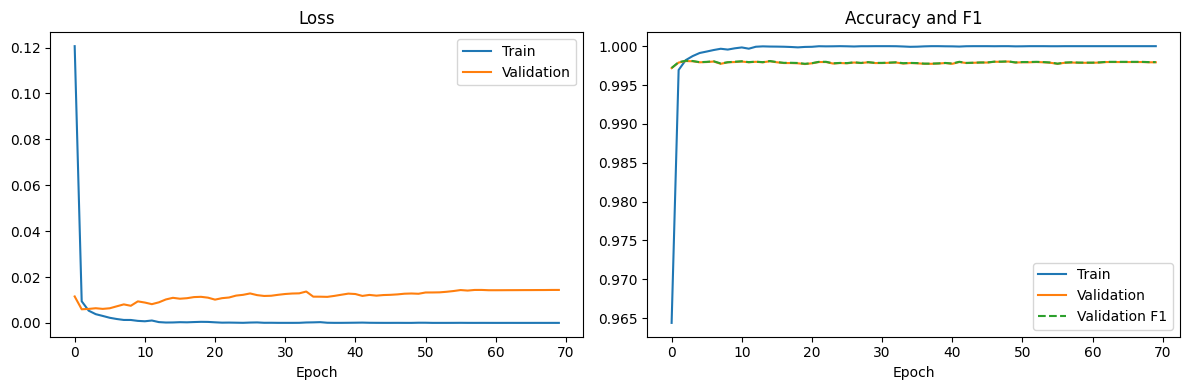

In [14]:
# Plot training results
%mkdir images
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train')
plt.plot(results['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['train_accuracy'], label='Train')
plt.plot(results['val_accuracy'], label='Validation')
plt.plot(results['val_f1'], label='Validation F1', linestyle='--')
plt.title('Accuracy and F1')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('images/ner_training_curves.png')
plt.show()

In [15]:
# Function to use the trained model for prediction
def predict_diseases(text, model, tokenizer):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    token_tags = [(token, 'O') for token in tokens]  # Initialize with 'O' tags

    # Process with BERT
    bert_input = prepare_bert_input(token_tags, tokenizer)

    # Convert to tensors
    input_ids = torch.tensor(bert_input['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(bert_input['attention_mask']).unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2).squeeze(0).cpu().numpy()

    # Map predictions back to tokens
    id2tag = {0: 'O', 1: 'B-DISEASE', 2: 'I-DISEASE'}
    tagged_tokens = []
    word_ids = tokenizer(tokens, is_split_into_words=True).word_ids()

    for i, word_idx in enumerate(word_ids):
        if word_idx is not None:  # Skip special tokens
            if i < len(predictions):
                prediction = id2tag[predictions[i]]
                if word_idx >= len(tagged_tokens):
                    tagged_tokens.append((tokens[word_idx], prediction))
                # Otherwise skip (word piece continuation)

    # Extract disease entities
    diseases = []
    current_disease = []

    for token, tag in tagged_tokens:
        if tag == 'B-DISEASE':
            if current_disease:
                diseases.append(' '.join(current_disease))
                current_disease = []
            current_disease.append(token)
        elif tag == 'I-DISEASE' and current_disease:
            current_disease.append(token)
        elif current_disease:
            diseases.append(' '.join(current_disease))
            current_disease = []

    if current_disease:
        diseases.append(' '.join(current_disease))

    return {
        'text': text,
        'tokens': tokens,
        'tagged_tokens': tagged_tokens,
        'extracted_diseases': diseases
    }

# Example usage:
test_text = "Patient has a history of hypertension and type 2 diabetes."
result = predict_diseases(test_text, model, tokenizer)
print(f"Text: {result['text']}")
print(f"Tagged tokens: {result['tagged_tokens']}")
print(f"Extracted diseases: {result['extracted_diseases']}")

# Save the final model
final_model_path = os.path.join('models', 'bert_ner_final')
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

# Save evaluation results and model information
with open(os.path.join(final_model_path, 'model_info.txt'), 'w') as f:
    f.write(f"Training completed with {num_epochs} epochs\n")
    f.write(f"Final validation accuracy: {results['val_accuracy'][-1]:.4f}\n")
    f.write(f"Final validation F1 score: {results['val_f1'][-1]:.4f}\n")
    f.write(f"Best validation F1 score: {best_val_f1:.4f}\n")

Text: Patient has a history of hypertension and type 2 diabetes.
Tagged tokens: [('Patient', 'O'), ('has', 'O'), ('a', 'O'), ('history', 'O'), ('of', 'O'), ('hypertension', 'B-DISEASE'), ('and', 'O'), ('type', 'B-DISEASE'), ('2', 'I-DISEASE'), ('diabetes', 'I-DISEASE'), ('.', 'O')]
Extracted diseases: ['hypertension', 'type 2 diabetes']


In [18]:
# Create a comprehensive metrics table
import pandas as pd
import numpy as np

# Extract the last epoch's validation metrics (already have accuracy and f1)
val_accuracy = results['val_accuracy'][-1]
val_f1 = results['val_f1'][-1]

# We need to calculate precision and recall
# Load validation data and get predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predictions
        preds = torch.argmax(logits, dim=2).detach().cpu().numpy()
        label_ids = labels.detach().cpu().numpy()

        all_preds.append(preds)
        all_labels.append(label_ids)

# Flatten the predictions and labels for metrics calculation
all_preds_flat = np.concatenate([p.flatten() for p in all_preds])
all_labels_flat = np.concatenate([l.flatten() for l in all_labels])

# Remove padding (-100) tokens
mask = all_labels_flat != -100
all_preds_flat = all_preds_flat[mask]
all_labels_flat = all_labels_flat[mask]

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# For binary metrics, we'll treat disease tags (1 and 2) as positive class
binary_preds = (all_preds_flat > 0).astype(int)
binary_labels = (all_labels_flat > 0).astype(int)

# Calculate metrics
precision = precision_score(binary_labels, binary_preds)
recall = recall_score(binary_labels, binary_preds)
f1 = f1_score(binary_labels, binary_preds)
accuracy = accuracy_score(binary_labels, binary_preds)

# For AUC, we need probabilities
prob_preds = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get probability for disease tags (average of class 1 and 2)
        probs = torch.softmax(logits, dim=2)
        disease_probs = probs[:,:,1:].mean(dim=2).detach().cpu().numpy()
        prob_preds.append(disease_probs)

prob_preds_flat = np.concatenate([p.flatten() for p in prob_preds])
prob_preds_flat = prob_preds_flat[:len(binary_labels)]  # Match lengths

# Calculate AUC
auc_score = roc_auc_score(binary_labels, prob_preds_flat)

# Create metrics table
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC': [auc_score],
})

import pickle
%mkdir models/bert_ner_eval

# Save the metrics to a pickle file
with open('models/bert_ner_eval/ner_metrics.pkl', 'wb') as f:
    pickle.dump(metrics_df, f)

with open('models/bert_ner_eval/binary_labels.pkl', 'wb') as f:
    pickle.dump(binary_labels, f)

with open('models/bert_ner_eval/prob_preds_flat.pkl', 'wb') as f:
    pickle.dump(prob_preds_flat, f)

In [20]:
# zip the models directory
!zip -r models.zip models
!zip -r images.zip images

# download from colab
from google.colab import files

# download the models and images
files.download('images.zip')

!echo "Download complete. You can now use the trained model for predictions."

updating: models/ (stored 0%)
updating: models/bert_ner_eval/ (stored 0%)
updating: models/bert_ner_eval/ner_metrics.pkl (deflated 31%)
updating: models/bert_ner_eval/binary_labels.pkl (deflated 100%)
updating: models/bert_ner_eval/prob_preds_flat.pkl (deflated 32%)
updating: models/bert_ner_best/ (stored 0%)
updating: models/bert_ner_best/model.safetensors (deflated 7%)
updating: models/bert_ner_best/training_results.pt (deflated 54%)
updating: models/bert_ner_best/vocab.txt (deflated 49%)
updating: models/bert_ner_best/tokenizer_config.json (deflated 74%)
updating: models/bert_ner_best/config.json (deflated 51%)
updating: models/bert_ner_best/tokenizer.json (deflated 70%)
updating: models/bert_ner_best/special_tokens_map.json (deflated 42%)
updating: models/bert_ner_best/tag_mapping.json (deflated 26%)
updating: models/bert_ner_final/ (stored 0%)
updating: models/bert_ner_final/model.safetensors (deflated 7%)
updating: models/bert_ner_final/model_info.txt (deflated 34%)
updating: mod

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete. You can now use the trained model for predictions.


In [21]:
files.download('models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 1.2 Save The Model To Hugging Face

In [ ]:
from huggingface_hub import HfApi, login

# set up login
login()

# Define your model repository name (create this on the HF website first)
model_name = "keanteng/bert-ner-wqd7005"  # Replace with your desired repo name

In [ ]:
# Push the model to Hugging Face Hub
api = HfApi()
api.upload_folder(
    folder_path=f"models/bert_ner_best",
    repo_id=model_name,
    repo_type="model"
)

In [ ]:
api.upload_folder(
    folder_path=f"models/bert_ner_eval",
    repo_id=model_name,
    repo_type="model",
    path_in_repo="evaluation"
)

In [ ]:
api.upload_folder(
    folder_path=f"models/bert_ner_final",
    repo_id=model_name,
    repo_type="model",
    path_in_repo="final_model"
)

Write model card information to the model card file. This will allow us to save the model to Hugging Face.

In [ ]:
# Add a model card with description
with open(f"README.md", "w") as f:
    f.write("""---
license: agpl-3.0
language:
- en
base_model:
- emilyalsentzer/Bio_ClinicalBERT
pipeline_tag: token-classification
library_name: transformers
tags:
- named-entity-recognition
- ner
- medical
- disease-extraction
- healthcare
- bert
- clinical-bert
- fine-tuned
- pytorch
- bio-tagging
datasets:
- custom
widget:
- text: "Patient has a history of hypertension and type 2 diabetes."
  example_title: "Medical History Example"

---

# BERT for Medical Named Entity Recognition (Disease Extraction)

## Model Description

This model is a fine-tuned version of [emilyalsentzer/Bio_ClinicalBERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT) for Named Entity Recognition (NER) specifically designed to extract disease names from medical text. The model uses BIO tagging schema to identify and classify disease entities in clinical narratives.

## Model Details

- **Base Model**: emilyalsentzer/Bio_ClinicalBERT
- **Task**: Token Classification (Named Entity Recognition)
- **Domain**: Medical/Healthcare
- **Target Entities**: Diseases
- **Tagging Schema**: BIO (Beginning-Inside-Outside)
- **Labels**: 
  - `O`: Outside (not a disease entity)
  - `B-DISEASE`: Beginning of a disease entity
  - `I-DISEASE`: Inside/continuation of a disease entity

## Training Details

- **Training Epochs**: 50
- **Batch Size**: 16
- **Learning Rate**: 2e-5
- **Optimizer**: AdamW
- **Scheduler**: Linear schedule with warmup
- **Max Sequence Length**: 128 tokens
- **Train/Validation Split**: 80/20

## Performance Metrics

The model achieved the following performance on the validation set:
- **Accuracy**: [Will be filled with actual values]
- **Precision**: [Will be filled with actual values] 
- **Recall**: [Will be filled with actual values]
- **F1 Score**: [Will be filled with actual values]
- **AUC**: [Will be filled with actual values]

## Usage

### Quick Start

```python
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import nltk

# Load model and tokenizer
model_name = "keanteng/bert-sentiment-wqd7007"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Example text
text = "Patient has a history of hypertension and type 2 diabetes."

# Tokenize
tokens = nltk.word_tokenize(text)
inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True)

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)

# Map predictions to labels
id2label = {0: 'O', 1: 'B-DISEASE', 2: 'I-DISEASE'}
predicted_labels = [id2label[pred.item()] for pred in predictions[0]]

# Extract diseases
diseases = []
current_disease = []
word_ids = inputs.word_ids()

for i, (word_idx, label) in enumerate(zip(word_ids, predicted_labels)):
    if word_idx is not None and word_idx < len(tokens):
        if label == 'B-DISEASE':
            if current_disease:
                diseases.append(' '.join(current_disease))
                current_disease = []
            current_disease.append(tokens[word_idx])
        elif label == 'I-DISEASE' and current_disease:
            current_disease.append(tokens[word_idx])
        elif current_disease:
            diseases.append(' '.join(current_disease))
            current_disease = []

if current_disease:
    diseases.append(' '.join(current_disease))

print(f"Extracted diseases: {diseases}")
```

### Using the Prediction Function

```python
def predict_diseases(text, model, tokenizer):
    import nltk
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    token_tags = [(token, 'O') for token in tokens]
    
    # Prepare BERT input
    inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", 
                      padding=True, truncation=True, max_length=128)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2).squeeze(0).numpy()
    
    # Map predictions to labels
    id2tag = {0: 'O', 1: 'B-DISEASE', 2: 'I-DISEASE'}
    
    # Extract diseases
    diseases = []
    current_disease = []
    word_ids = inputs.word_ids()
    
    for i, word_idx in enumerate(word_ids):
        if word_idx is not None and i < len(predictions):
            prediction = id2tag[predictions[i]]
            if word_idx < len(tokens):
                if prediction == 'B-DISEASE':
                    if current_disease:
                        diseases.append(' '.join(current_disease))
                        current_disease = []
                    current_disease.append(tokens[word_idx])
                elif prediction == 'I-DISEASE' and current_disease:
                    current_disease.append(tokens[word_idx])
                elif current_disease:
                    diseases.append(' '.join(current_disease))
                    current_disease = []
    
    if current_disease:
        diseases.append(' '.join(current_disease))
    
    return diseases

# Example usage
text = "Patient diagnosed with hypertension, diabetes mellitus, and chronic kidney disease."
diseases = predict_diseases(text, model, tokenizer)
print(f"Extracted diseases: {diseases}")
```

## Training Data

The model was trained on a custom dataset of medical patient records containing:
- Medical history narratives
- Manually extracted disease entities
- BIO-tagged training examples

## Limitations

- The model is specifically trained for disease entity extraction
- Performance may vary on medical texts from different domains or institutions
- May not capture very rare or newly named diseases not seen during training
- Limited to English language medical texts

## Ethical Considerations

- This model is intended for research and educational purposes
- Should not be used as a substitute for professional medical diagnosis
- Patient privacy and data protection must be ensured when using this model
- Results should be validated by medical professionals
""")

In [ ]:
api.upload_file(
    path_or_fileobj=f"README.md",
    path_in_repo="README.md",
    repo_id=model_name,
    repo_type="model"
)

In [ ]:
api.upload_folder(
    folder_path=f"images",
    repo_id=f"{model_name}",
    repo_type="model",
    path_in_repo="images/entity_name_recognition"
)